In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


/u/f/fcaretti/miniforge3/envs/bioenv/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/u/f/fcaretti/miniforge3/envs/bioenv/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda:0


# Introduction to VAEs
Variational Autoencoders are, in practice, the most common form of Black Box Variational Inference (BBVI). Here we will only look at them from a practical point of view. In particular, we will stress the differences with normal autoencoders, mainly used for dimensionality reduction.

## Normal Autoencoders

In [9]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Output: 16 x 14 x 14
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # Output: 32 x 7 x 7
            nn.ReLU(True),
            nn.Flatten(),  # Flatten for the linear layers
            nn.Linear(32 * 7 * 7, 10)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 32 * 7 * 7),
            nn.Unflatten(1, (32, 7, 7)),  # Unflatten to 32 x 7 x 7
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # Output: 16 x 14 x 14
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # Output: 1 x 28 x 28
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z
    

# Display some original and reconstructed images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [13]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = torch.utils.data.Subset(train_dataset, range(10000))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader_2 = torch.utils.data.DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = torch.utils.data.Subset(test_dataset, range(1000))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the network and the optimizer
AE = ConvAutoencoder().to(device)
optimizer = torch.optim.SGD(AE.parameters(), lr=0.00001, momentum=0.9)
criterion = nn.MSELoss(reduction='sum')

In [15]:
# Train the Autoencoder
n_epochs = 5
for epoch in range(n_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), 1, 28, 28).to(device)
        # Forward pass
        output, _ = AE(img)
        loss = criterion(output, img)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluation phase
    AE.eval()  # Set the network to evaluation mode

    # Calculate training loss over the entire training set
    train_loss = 0
    with torch.no_grad():  # No need to track gradients
        for img,_ in train_loader:
            img.to(device)
            img = img.view(img.size(0), 1, 28, 28).to(device)
            train_output,_ = AE(img)
            train_loss += criterion(train_output, img).item()           
    train_loss /= len(train_loader)

    # Same for test
    test_loss = 0
    with torch.no_grad():
        for img,_ in test_loader:
            img.to(device)  
            img = img.view(img.size(0), 1, 28, 28).to(device)
            test_output,_ = AE(img)
            test_loss += criterion(test_output, img).item()
    test_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}')

Epoch 1/5 - Train Loss: 6916.070514654658, Test Loss: 6785.537841796875
Epoch 2/5 - Train Loss: 6155.5685024382965, Test Loss: 6059.098098754883
Epoch 3/5 - Train Loss: 5605.674974963923, Test Loss: 5582.053863525391
Epoch 4/5 - Train Loss: 5351.583018697751, Test Loss: 5364.037750244141
Epoch 5/5 - Train Loss: 5179.4435661947655, Test Loss: 5207.493835449219


In [17]:
#after training, put back the network in the cpu
AE.to('cpu')

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1568, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1568, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(32, 7, 7))
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [20]:
AE.eval()
with torch.no_grad():
    # Get a batch of data
    images, labels = next(iter(train_loader_2))
    #if convolutional
    images = images.view(images.size(0), 1, 28, 28)
    _, representations = AE(images)


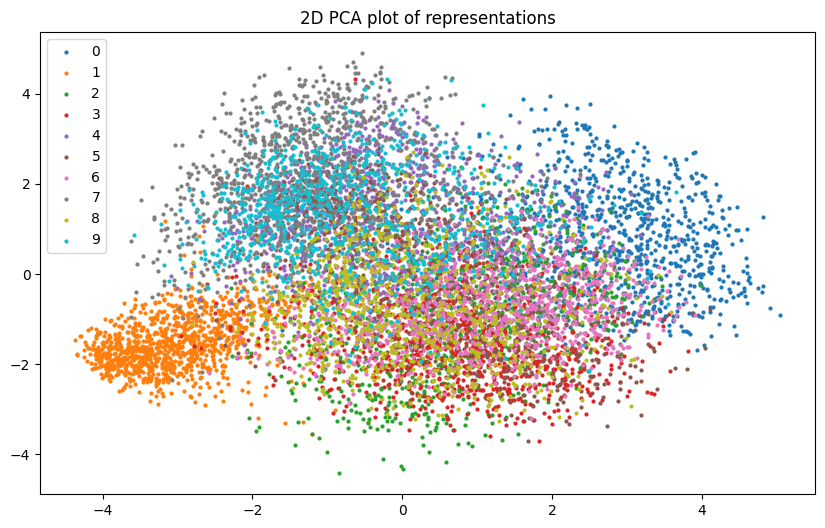

In [23]:
#do PCA instead
pca = PCA(n_components=2)
representations_2d = pca.fit_transform(representations)
# Plot the resulting points
plt.figure(figsize=(10, 6))
for i in range(10):
    indices = labels == i
    plt.scatter(representations_2d[indices, 0], representations_2d[indices, 1], label=str(i), alpha=1, s=4)
plt.legend()
plt.title('2D PCA plot of representations')
plt.show()

In [24]:
# Number of images to display
num_images = 6

# Get a batch of test images
images, _ = next(iter(test_loader))
original_images = images  # Save the original images for comparison


AE.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    #images = images.view(images.size(0), -1)
    #if convolutional
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, latent = AE(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format

Original Images


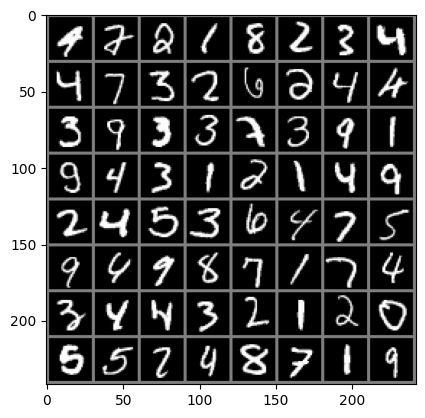

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


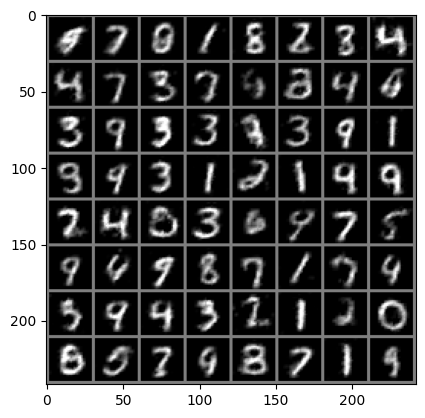

In [25]:


# Display original images
print("Original Images")
imshow(torchvision.utils.make_grid(original_images))
plt.show()

# Display reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(reconstructed))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


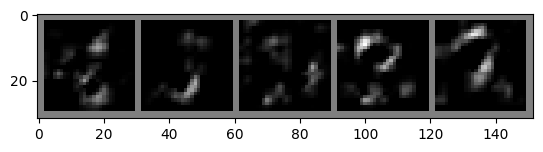

In [26]:
#how to "sample" from the latent space?
#generate random numbers from a normal distribution
#feed them through the decoder

latent_space_samples = torch.randn(5, 10)
output = AE.decoder(latent_space_samples)
output = output.view(-1, 1, 28, 28)

# Display reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(output))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 6, 9, 9, 0, 5, 6, 3, 6, 1])


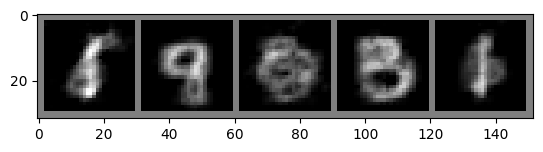

In [27]:
#feed 10 images in the encoder and get the latent representations
# Get a batch of test images
images, labels = next(iter(test_loader))
original_images = images  # Save the original images for comparison

print(labels[:10])
AE.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, latent = AE(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format
    reconstructed = reconstructed[:10]

pair_means = []
for i in range(0, len(reconstructed), 2):  # Step by 2
    if i+1 < len(reconstructed):  # Check if there is a pair
        mean_img = 0.5 * (reconstructed[i] + reconstructed[i+1])  # Calculate the mean
        pair_means.append(mean_img)

imshow(torchvision.utils.make_grid(pair_means))

## Ok, now let's try to do the same with a VAE!

In [28]:
#this needs two big modifications: one in the actual model, and one in the loss function

class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Flatten()
        )
        self.get_mu = nn.Linear(32 * 7 * 7, 10)
        self.get_logvar = nn.Linear(32 * 7 * 7, 10)

        # Decoder
        self.decoder_fc = nn.Linear(10, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.get_mu(encoded)
        logvar = self.get_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        return self.decoder(self.decoder_fc(z)), mu, logvar
    

def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [29]:
VAE = ConvVAE()
optimizer = torch.optim.SGD(VAE.parameters(), lr=0.00001, weight_decay=1e-5, momentum=0.9)
criterion = nn.MSELoss(reduction='sum')

In [30]:
n_epochs = 5

# Calculate training loss over the entire training set
train_loss = 0
with torch.no_grad():  # No need to track gradients
    for img,_ in train_loader:
        #img = img.view(img.size(0), -1)
        #if convolutional
        img = img.view(img.size(0), 1, 28, 28)
        train_output, mu, logvar = VAE(img)
        train_loss += ((criterion(train_output, img)+kl_divergence(mu,logvar)).item()/img.size(0))           
train_loss /= len(train_loader)
print(f'Initial Train Loss: {train_loss}')

for epoch in range(n_epochs):
    for data in train_loader:
        img, _ = data
        #img = img.view(img.size(0), -1)
        #if convolutional
        img = img.view(img.size(0), 1, 28, 28)
        # Forward pass
        output, mu, logvar = VAE(img)
        loss = criterion(output, img)+kl_divergence(mu, logvar)
        #loss = criterion(output, img)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluation phase
    VAE.eval()  # Set the network to evaluation mode

    # Calculate training loss over the entire training set
    train_loss = 0
    with torch.no_grad():  # No need to track gradients
        for img,_ in train_loader:
            #img = img.view(img.size(0), -1)
            #if convolutional
            img = img.view(img.size(0), 1, 28, 28)
            train_output, mu, logvar = VAE(img)
            train_loss += ((criterion(train_output, img)+kl_divergence(mu,logvar)).item()/img.size(0))           
    train_loss /= len(train_loader)

    # Same for test
    test_loss = 0
    with torch.no_grad():
        for img,_ in test_loader:
            #img = img.view(img.size(0), -1)
            #if convolutional
            img = img.view(img.size(0), 1, 28, 28)
            test_output, mu, logvar = VAE(img)
            test_loss += ((criterion(test_output, img)+kl_divergence(mu,logvar)).item()/img.size(0))
    test_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}')

Initial Train Loss: 484.4954003984002
Epoch 1/5 - Train Loss: 128.00462739786525, Test Loss: 128.64735164642335
Epoch 2/5 - Train Loss: 122.88269310240533, Test Loss: 123.58190412521363
Epoch 3/5 - Train Loss: 121.12453713386681, Test Loss: 121.55692195892334
Epoch 4/5 - Train Loss: 115.79784991027444, Test Loss: 116.84663162231445
Epoch 5/5 - Train Loss: 116.28460260865036, Test Loss: 117.7756721496582


In [31]:
# Get a batch of test images
images, _ = next(iter(test_loader))
original_images = images  # Save the original images for comparison


VAE.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    #images = images.view(images.size(0), -1)
    #if convolutional
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, mu, logvar = VAE(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format
    print(latent.shape)

torch.Size([64, 10])


Original Images


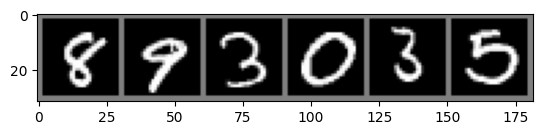

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


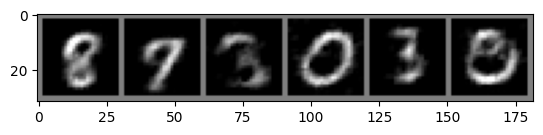

In [32]:
# Number of images to display
num_images = 6

# Display original images
print("Original Images")
imshow(torchvision.utils.make_grid(original_images[:num_images]))
plt.show()

# Display reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(reconstructed[:num_images]))
plt.show()

In [33]:
VAE.eval()
with torch.no_grad():
    # Get a batch of data
    images, labels = next(iter(train_loader_2))
    #if convolutional
    images = images.view(images.size(0), 1, 28, 28)
    #images = images.view(images.size(0), -1)
    # Forward pass through the encoder
    _, representations, _ = VAE(images)

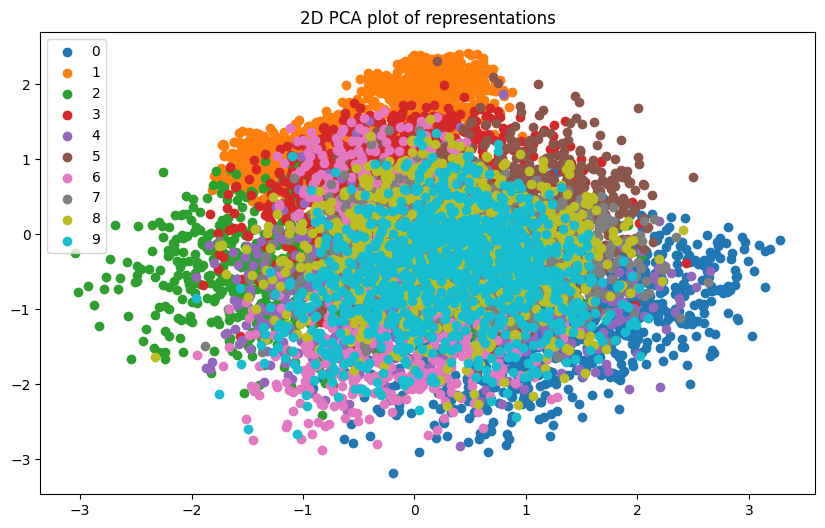

In [34]:
#do PCA instead
pca = PCA(n_components=2)
representations_2d = pca.fit_transform(representations)
representations_2d = representations[:, :2].numpy()
# Plot the resulting points
plt.figure(figsize=(10, 6))
for i in range(10):
    indices = labels == i
    plt.scatter(representations_2d[indices, 0], representations_2d[indices, 1], label=str(i), alpha=1)
plt.legend()
plt.title('2D PCA plot of representations')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


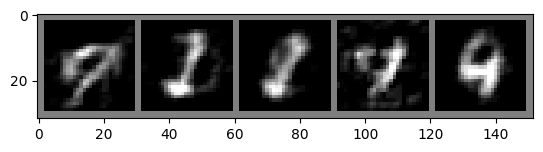

In [35]:
#generate random numbers from a normal distribution
#feed them through the decoder

latent_space_samples = torch.randn(5, 10)
output = VAE.decoder(VAE.decoder_fc(latent_space_samples))
output = output.view(-1, 1, 28, 28)

# Display reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(output))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 1, 28, 28])


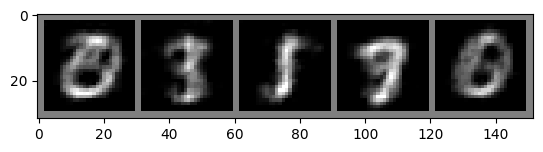

In [36]:
#feed 10 images in the encoder and get the latent representations
# Get a batch of test images
images, _ = next(iter(test_loader))
original_images = images  # Save the original images for comparison

AE.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    images = images.view(images.size(0), 1, 28, 28)
    reconstructed, latent = AE(images)
    reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to image format
    reconstructed = reconstructed[:10]
    print(reconstructed.shape)

pair_means = []
for i in range(0, len(reconstructed), 2):  # Step by 2
    if i+1 < len(reconstructed):  # Check if there is a pair
        mean_img = 0.5 * (reconstructed[i] + reconstructed[i+1])  # Calculate the mean
        pair_means.append(mean_img)

imshow(torchvision.utils.make_grid(pair_means))

## Let's get fancier, and move to CIFAR10
### Please notice: run the following code only if you have a GPU available

In [59]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(32 * 8 * 8, 64)
        self.fc_logvar = nn.Linear(32 * 8 * 8, 64)

        # Decoder
        self.decoder_fc = nn.Linear(64, 32 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 8, 8)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        return self.decoder(self.decoder_fc(z)), mu, logvar

In [71]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # Output: 32 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # Output: 64 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),# Output: 128 x 4 x 4
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, 128)
        self.fc_logvar = nn.Linear(128 * 4 * 4, 128)

        # Decoder
        self.decoder_fc = nn.Linear(128, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        return self.decoder(self.decoder_fc(z)), mu, logvar

In [72]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Selecting only one class, cats (3)
class_indices = [0]
indices = [i for i, (_, label) in enumerate(train_dataset) if label in class_indices]
subset_train_dataset = torch.utils.data.Subset(train_dataset, indices)

test_indices = [i for i, (_, label) in enumerate(test_dataset) if label in class_indices]
subset_test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(subset_test_dataset, batch_size=len(test_dataset), shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [73]:
VAE = ConvVAE().to(device)
optimizer = torch.optim.Adam(VAE.parameters(), lr=0.001)
criterion = nn.MSELoss(reduction='sum')

n_epochs = 40
for epoch in range(n_epochs):
    VAE.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed, mu, logvar = VAE(images)
        reconstruction_loss = criterion(reconstructed, images)
        kl_loss = kl_divergence(mu, logvar)
        loss = reconstruction_loss + kl_loss
        loss.backward()
        optimizer.step()

    # Evaluation phase
    VAE.eval()  # Set the network to evaluation mode

    # Calculate training loss over the entire training set
    train_loss = 0
    with torch.no_grad():  # No need to track gradients
        for images,_ in train_loader:
            images = images.to(device)
            train_output, mu, logvar = VAE(images)
            train_loss += ((criterion(train_output, images)+kl_divergence(mu,logvar)).item()/images.size(0))           
    train_loss /= len(train_loader)

    # Same for test
    test_loss = 0
    with torch.no_grad():
        for images,_ in test_loader:
            images = images.to(device)
            test_output, mu, logvar = VAE(images)
            test_loss += ((criterion(test_output, images)+kl_divergence(mu,logvar)).item()/images.size(0))
    test_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}')
        

Epoch 1/40 - Train Loss: 378.0323474739171, Test Loss: 368.32115625
Epoch 2/40 - Train Loss: 325.45728311659417, Test Loss: 318.5210625
Epoch 3/40 - Train Loss: 277.88268173797223, Test Loss: 272.7086875
Epoch 4/40 - Train Loss: 262.59855883634543, Test Loss: 259.3299375
Epoch 5/40 - Train Loss: 237.32880565788173, Test Loss: 234.358375
Epoch 6/40 - Train Loss: 225.59360185454165, Test Loss: 223.15834375
Epoch 7/40 - Train Loss: 212.22458986692791, Test Loss: 209.96240625
Epoch 8/40 - Train Loss: 205.7633879456339, Test Loss: 204.85728125
Epoch 9/40 - Train Loss: 205.73486753053302, Test Loss: 205.036796875
Epoch 10/40 - Train Loss: 199.7499951712693, Test Loss: 198.1989375
Epoch 11/40 - Train Loss: 194.2261543756799, Test Loss: 193.98778125
Epoch 12/40 - Train Loss: 193.99356639234327, Test Loss: 193.26009375
Epoch 13/40 - Train Loss: 189.91704704188092, Test Loss: 189.964578125
Epoch 14/40 - Train Loss: 198.82586206363726, Test Loss: 198.636703125
Epoch 15/40 - Train Loss: 184.827680

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

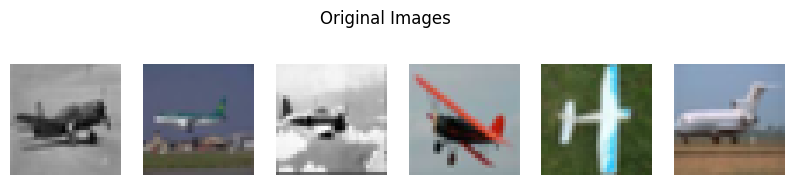

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


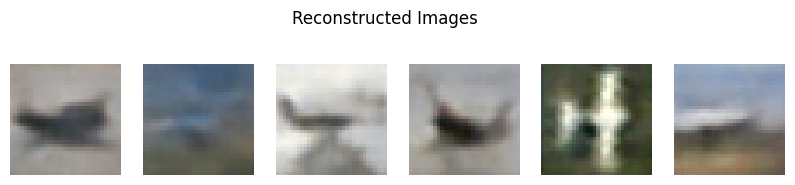

In [76]:
# Get a batch of images from the test set
images, _ = next(iter(train_loader))
images = images.to(device)

# Forward pass through VAE
VAE.eval()
with torch.no_grad():
    reconstructed, _, _ = VAE(images)

# Compare original and reconstructed images
images = images.cpu()
reconstructed = reconstructed.cpu()

# Display original images
plt.figure(figsize=(10, 4))
plt.suptitle('Original Images')
for i in range(6):
    plt.subplot(2, 6, i+1)
    imshow(torchvision.utils.make_grid(images[i]))
plt.show()

# Display reconstructed images
plt.figure(figsize=(10, 4))
plt.suptitle('Reconstructed Images')
for i in range(6):
    plt.subplot(2, 6, i+1)
    imshow(torchvision.utils.make_grid(reconstructed[i]))
plt.show()

In [70]:
# Generate and display images from the latent space
num_samples = 6
z = torch.randn(num_samples, 64).to(device)  # Randomly sample latent variables

with torch.no_grad():
    sampled_images = VAE.decoder(z).cpu()

plt.figure(figsize=(10, 2))
plt.suptitle('Sampled Images from the Posterior')
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    imshow(torchvision.utils.make_grid(sampled_images[i]))
plt.show()

RuntimeError: unflatten: Provided sizes [32, 8, 8] don't multiply up to the size of dim 1 (64) in the input tensor